# Joc de dades

En aquest notebook processarem el joc de dades INbreast, que conté 410 mamografies digitals a camp complet (FFDM) provinents de 115 casos (4 vistes per pacient en casos de dues mames i 2 vistes en mastectomies), amb resolucions de 2560 × 3328 o 3328 × 4084 píxels i 14 bits de profunditat. Cada imatge inclou anotacions píxel‑a‑píxel realitzades per especialistes (contorns de masses, microcalcificacions, distorsions, asimetries i múscul pectoral) i metadades clau com el BI‑RADS (categories 0–6) i la densitat mamària segons l’ACR, emmagatzemades en fitxers XML.

# Exploratory Data Analysis

## Exploració del fitxer csv

El fitxer INbreast.csv conté informació sobre cada pacient i permet relacionar la ID del pacient (File Name) amb la presència d'un càncer maligne.

In [1]:
import pandas as pd

csv_path = "INbreast Release 1.0\INbreast.csv"
df = pd.read_csv(csv_path, sep =';')

df.head()

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads
0,removed,removed,R,CC,201001,22678622,4,1
1,removed,removed,L,CC,201001,22678646,4,3
2,removed,removed,R,MLO,201001,22678670,4,1
3,removed,removed,L,MLO,201001,22678694,4,3
4,removed,removed,R,CC,201001,22614074,2,5


Observem que hi ha molta informació que no necessitem així que simplificarem el nostre dataframe. A "inbreast.pdf" està explicat com es classifiquen les mamografies. En aquest cas només ens interessa la columna "Bi-Rads" i hem de tindre en compte la següent taula a l'hora de transformar-ho en un cas de classificació binària.

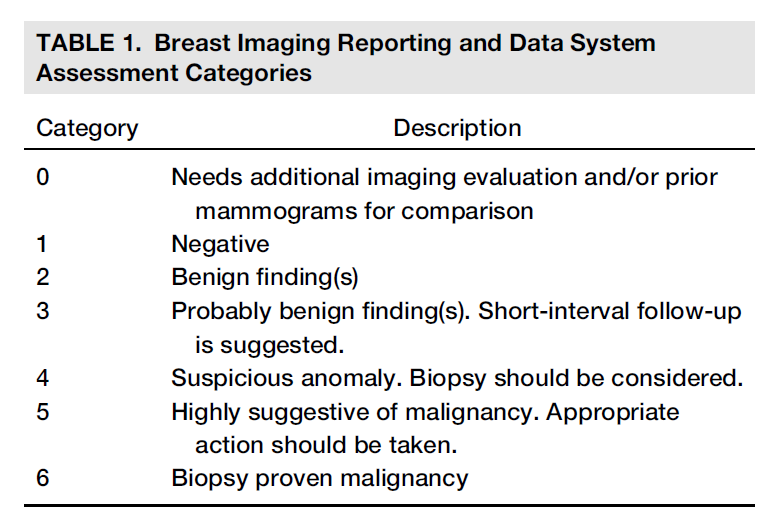

Tenint en compte aquesta informació, primer mirarem que els valors de la columna Bi-Rads tinguin els valors esperats i a continuació farem una columna nova per a la variable objectiu de la classificació.

In [2]:
col_eliminar = ["Patient ID", "Patient age", "Laterality", "View", "Acquisition date", "ACR"]
df = df.drop(columns=[col for col in col_eliminar if col in df.columns])
df.head()

,File Name,Bi-Rads
0,22678622,1
1,22678646,3
2,22678670,1
3,22678694,3
4,22614074,5


In [3]:
valors_bi_rads = df["Bi-Rads"].unique()
print("Valors únics a la columna 'Bi-Rads':")
print(sorted(valors_bi_rads))

Valors únics a la columna 'Bi-Rads':
['1', '2', '3', '4a', '4b', '4c', '5', '6']


Observem que hi ha subtipus de valors de classe 4. Els agruparem tots en una sola classe.

In [4]:
df["Bi-Rads"] = df["Bi-Rads"].replace({'4a': '4', '4b': '4', '4c': '4'})

In [5]:
valors_bi_rads = df["Bi-Rads"].unique()
print("Valors únics a la columna 'Bi-Rads':")
print(sorted(valors_bi_rads))

Valors únics a la columna 'Bi-Rads':
['1', '2', '3', '4', '5', '6']


Els registres amb Bi-Rads = 0 seran eliminats, els que siguin menors que 4 es consideraran com no malignes i els que tinguin valor 4 o major seran considerats malignes. Abans, però mirarem quants registres hi ha a l'inici i al final de l'anàlisi.

In [6]:
print(f"Nombre total de registres: {len(df)}")

Nombre total de registres: 410


Eliminem els registres amb Bi-Rads = 0, creem la columna "Malignant" que tindrà valor 0 si no és maliciós i 1 en cas contrari.

In [7]:
df = df[df["Bi-Rads"] != '0']
df["Malignant"] = df["Bi-Rads"].astype(str).apply(lambda x: 1 if x in ['4', '5', '6'] else 0)

In [8]:
print(f"Nombre total de registres després de filtrar: {len(df)}")

Nombre total de registres després de filtrar: 410


No hem eliminat cap registre, ja que no n'hi ha cap amb valor 0. De fet, si mirem els valors únics de la columna Bi-Rads, ja hem vist que no n'hi havia.

In [9]:
df.head()

,File Name,Bi-Rads,Malignant
0,22678622,1,0
1,22678646,3,0
2,22678670,1,0
3,22678694,3,0
4,22614074,5,1


Ja podem eliminar la columna Bi-Rads.

In [10]:
df = df.drop(columns=["Bi-Rads"])
df.head()

,File Name,Malignant
0,22678622,0
1,22678646,0
2,22678670,0
3,22678694,0
4,22614074,1


Arribats en aquest punt, podem mirar quin tant per cent hi ha de representació en cada classe.

In [11]:
import matplotlib.pyplot as plt

proporcions = df["Malignant"].value_counts().sort_index()

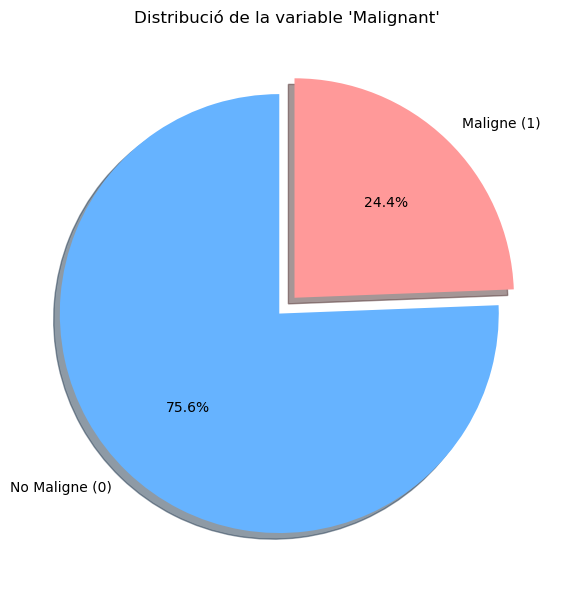

In [12]:
plt.figure(figsize=(6, 6))
proporcions.plot(
    kind='pie',
    labels=['No Maligne (0)', 'Maligne (1)'],
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0.05),
    shadow=True,
    colors=['#66b3ff', '#ff9999']
)

plt.title("Distribució de la variable 'Malignant'")
plt.ylabel('')
plt.tight_layout()
plt.show()

Podem veure que hi ha un desbalanceig important de les dades. Serà necessari l’ús de tècniques d’augment de dades per a incrementar la variabilitat de les imatges de la classe minoritària. Aquest procés ajudarà a millorar la generalització del model i a reduir el risc de sobreajustament, ja que exposarà la xarxa neuronal a múltiples transformacions (rotacions, zoom, desplaçaments, etc.) de les mateixes lesions, mantenint-ne la naturalesa mèdica.

**No es generaran imatges sintètiques amb una GAN, ja que en el context d’imatges mèdiques la generació artificial pot introduir artefactes o patrons irrealistes que podrien confondre el model i portar-lo a conclusions clíniques incorrectes**. A més, cal mantenir la veracitat anatòmica i la coherència clínica en les dades utilitzades per entrenar models en l’àmbit de la salut.

Abans, però explorarem les imatges del nostre joc de dades.

## Exploració de les mamografies

Les mamografies venen en format DICOM (.dcm), un estàndard utilitzat en imatge mèdica que combina la imatge pròpiament dita amb metadades clíniques rellevants, com ara informació del pacient, paràmetres de l’adquisició i detalls de l’equip utilitzat. Aquest format és essencial per assegurar la traçabilitat, interoperabilitat i qualitat diagnòstica dins dels sistemes PACS (Picture Archiving and Communication Systems) habituals als entorns hospitalaris. Per tal d’utilitzar aquestes imatges en un pipeline de Deep Learning, caldrà convertir-les a formats com PNG, preservant la qualitat diagnòstica i tenint en compte el processament de contrast i escales de grisos.

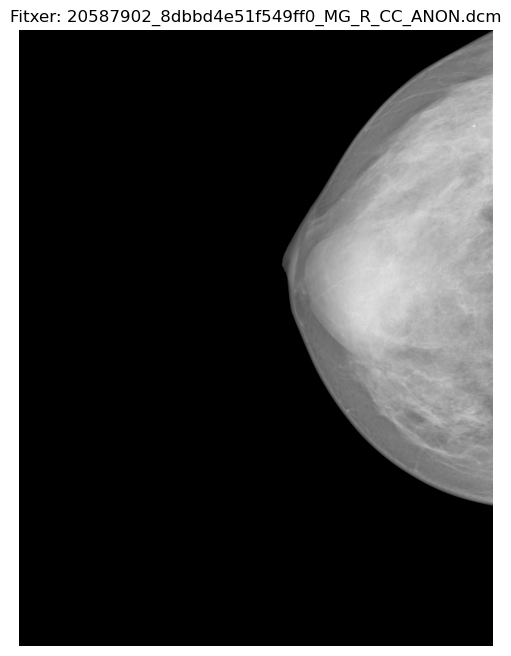

In [13]:
import random
import pydicom
import os

# Triar imàtge aleatòria
random.seed(123)
dicom_path = r'INbreast Release 1.0\AllDICOMs'
dicom_files = [f for f in os.listdir(dicom_path) if f.endswith('.dcm')]

# Visiualitzar
selected_file = random.choice(dicom_files)
full_path = os.path.join(dicom_path, selected_file)

dcm = pydicom.dcmread(full_path)
img = dcm.pixel_array

plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title(f"Fitxer: {selected_file}")
plt.axis('off')
plt.show()

Podem veure que hi ha molt d'espai en negre (sense informació pel model). A continuació retallarem les imatges per tal de maximitzar la informació per píxel introduïda al model.

In [14]:
import numpy as np

def normalitza_uint8(imatge: np.ndarray) -> np.ndarray:
    """
    Escala linealment un array NumPy a uint8 0–255.
    """
    img = imatge.astype(np.float32)
    img -= img.min()
    if img.max() != 0:
        img /= img.max()
    img *= 255.0
    return img.astype(np.uint8)


def retalla_negres(img: np.ndarray, tol: int = 0) -> np.ndarray:
    """
    Retalla marges negres: retorna només la regió amb píxels > tol.
    """
    mask = img > tol
    if not mask.any():
        return img
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    return img[y0:y1, x0:x1]



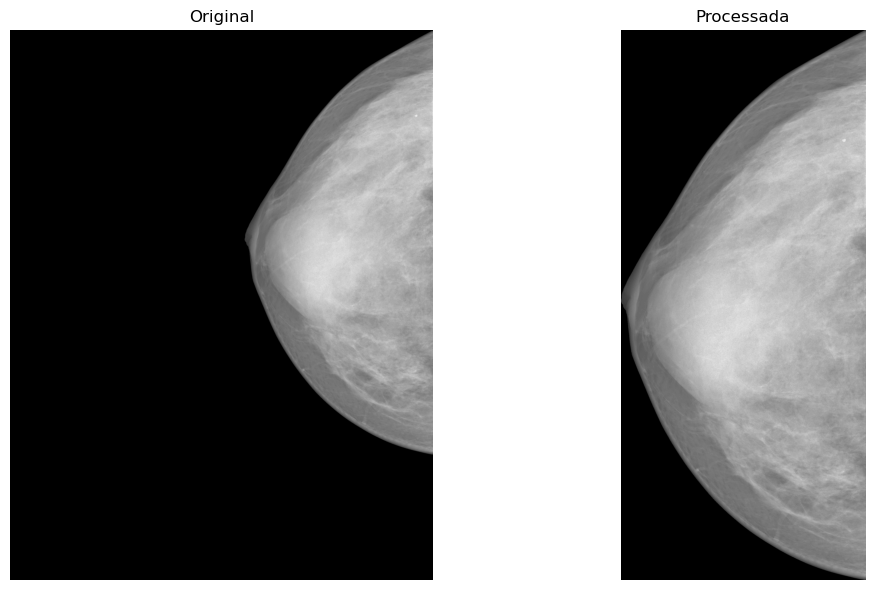

In [15]:
img = dcm.pixel_array
img8 = normalitza_uint8(img)

cropped = retalla_negres(img8, tol=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img8, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(cropped, cmap='gray')
axes[1].set_title("Processada")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [17]:
from PIL import Image

tots_png       = r"INbreast Release 1.0\AllPNGs"
crop_png       = r"INbreast Release 1.0\AllPNGsCrop"
os.makedirs(tots_png, exist_ok=True)
os.makedirs(crop_png, exist_ok=True)

# Processar tots els .dcm
for nom in os.listdir(dicom_path):
    if not nom.endswith(".dcm"):
        continue

    ruta = os.path.join(dicom_path, nom)
    dcm  = pydicom.dcmread(ruta)
    img  = dcm.pixel_array

    # Normalitzar a uint8
    img8 = normalitza_uint8(img)

    # Guardar la imatge sense retallar
    im = Image.fromarray(img8)
    nom_png = os.path.splitext(nom)[0] + ".png"
    im.save(os.path.join(tots_png, nom_png))

    # Retallar marges negres
    retallada = retalla_negres(img8, tol=0)

    # Guardar la versió retallada
    im_crop = Image.fromarray(retallada)
    im_crop.save(os.path.join(crop_png, nom_png))

Ara que ja tenim les imatges retallades, les modificarem perquè tinguin dimensió 224x224 píxels, que és l'estàndard dels models ViT i SwViT.

In [18]:
def redimensiona_imatges(carpeta_entrada: str, carpeta_sortida: str, mida=(224, 224)):
    """
    Redimensiona totes les imatges PNG d'una carpeta a la mida especificada
    """
    os.makedirs(carpeta_sortida, exist_ok=True)

    for fname in os.listdir(carpeta_entrada):
        if not fname.lower().endswith(".png"):
            continue

        path_entrada = os.path.join(carpeta_entrada, fname)
        img = Image.open(path_entrada).convert("L")
        img_resized = img.resize(mida, resample=Image.BICUBIC)

        path_sortida = os.path.join(carpeta_sortida, fname)
        img_resized.save(path_sortida)

    print(f"Imatges redimensionades a {mida[0]}x{mida[1]} i desades a:\n{carpeta_sortida}")
    


In [19]:
carpeta_entrada = r"INbreast Release 1.0\AllPNGsCrop"
carpeta_sortida  = r"INbreast Release 1.0\AllPNGs224"

redimensiona_imatges(carpeta_entrada, carpeta_sortida)

Imatges redimensionades a 224x224 i desades a:
INbreast Release 1.0\AllPNGs224


In [20]:
from PIL import Image

carpeta_sortida  = r"INbreast Release 1.0\AllPNGs224"

for fname in os.listdir(carpeta_sortida):
    if not fname.endswith(".png"):
        continue

    path = os.path.join(carpeta_sortida, fname)
    with Image.open(path) as img:
        assert img.size == (224, 224), f"Error: {fname} no té mida 224x224"

print(f"Totes les imatges de '{carpeta_sortida}' tenen mida 224x224.")

Totes les imatges de 'INbreast Release 1.0\AllPNGs224' tenen mida 224x224.
